In [2]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import utils as utl
import matplotlib.pyplot as plt
from IPython.display import display

## Introduction to all weather portfolio


The All Weather portfolio is a multi-asset portfolio pioneered by legendary hedge fund manager, Ray Dalio, and founder of one of the largest hedge funds, Bridgewtare Associates.

The objective of the portfolio is to 'weather' the different macoreconomic market regimes of rising and falling growth, and rising and falling inflation. This is acheieved by exposure to asset classes with low or negative correlation during these market regimes. For example, equities do well in rising growth regimes, bonds do well in falling growth regimes, gold outperforms during rising inflation and so on.

The strategy is also arguably the simplest macro strategy in that it has a dynamic multi-asset framework while,

1. fully systematic
2. requiring no optimization

Consequently the strategy has had longevity and the All Weather fund run by Ray Dalio's hedge fund, Bridgewater Associates, has been running for decades with a multi billion dollar AUM.

There are two main factors to consider: inflation and growth, each of those can rise or fall.

Based on these, we can expect 4 “seasons” of the economy:

+ Higher than expected inflation. 
+Lower than expected inflation. 
+Higher than expected economic growth. 
+Lower than expected economic growth.

<img src="img/season_all_weather.png" width="600">

The aim of the strategy is not only to balance risk across different environments, we also maximize diversification within each environment. The result is a portfolio that is more balanced than the conventional (60/40) portfolio both across and within asset classes.

This approach increases both efficiency an consistency of the portfolio. This is shown by studying the Sharpe ratio of the All Weather, it is much higher than a conventional one. This means that at the same level of expected risk, you can earn more return per year, or you can have the same expected return with less volatility per year (references [here](http://sdcera.granicus.com/MetaViewer.php?view_id=4&clip_id=75&meta_id=9141.#:~:text=The%20All%20Weather%20strategy%20was,returns%20with%20far%20less%20risk.&text=asset%20classes%20designed%20to%20achieve%20higher%20and%20more%20consistent%20returns) and [here](https://www.optimizedportfolio.com/all-weather-portfolio/)).


## The notebook
The notebook creates the portfolio based on the volatility's inverse of each securities. The volatility is estimated by using the standard deviation of the price. So it is created a data frame that shows in each line the inverse volatility of the securities on that day (based on the behavior of the 30 day before). This is the selection criteria to allocate the capital. To complete, it is necessary to normalize every row to get the percentage of the capital that it should be invested in that security during that day. 

After creating it, the portfolio is evaluated with the yfinance library. It is a good starting point but it needs some adjustment.
At the end of the notebook there is a function that compute the integer number of securities that make up the portfolio each day. Because it has to be an integer number for each security, some of the capital will not be invested (around 3%).

## Importing and and cleaning the data

In [3]:
data = pd.read_csv('./data/SSO_UBT_UST_UGL_historical_data.csv')
data.dropna(inplace= True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)
data

,SSO,UBT,UST,UGL
Date,,,,
2010-02-02,4.398681,16.248810,31.798561,45.980000
2010-02-03,4.356285,15.873260,31.498878,45.560001
2010-02-04,4.090126,16.373995,31.990910,41.970001
2010-02-05,4.111322,16.435442,32.201141,42.139999
2010-02-08,4.045374,16.506006,32.138515,41.709999
...,...,...,...,...
2022-03-14,55.750000,43.169998,61.369999,67.519997
2022-03-15,58.169998,43.029999,61.299999,65.070000
2022-03-16,60.779999,43.930000,61.049999,65.720001


In [261]:
#qs.plots.snapshot(data['SSO'], title='SSO Performance')
#qs.plots.snapshot(data['UBT'], title='UBT Performance')
#qs.plots.snapshot(data['UST'], title='UST Performance')
#qs.plots.snapshot(data['UGL'], title='UGL Performance')

In [5]:
data_r = data.div(data.shift(1))-1
data_r.dropna(inplace = True)
data_r.describe().T

,count,mean,std,min,25%,50%,75%,max
SSO,3053.0,0.001111,0.021598,-0.233582,-0.006918,0.001428,0.010879,0.188929
UBT,3053.0,0.000493,0.018160,-0.156310,-0.010335,0.001060,0.011245,0.130046
UST,3053.0,0.000242,0.007470,-0.036097,-0.004245,0.000361,0.004626,0.041853
UGL,3053.0,0.000315,0.019971,-0.176118,-0.009769,0.000647,0.010575,0.118644


## Studying the correlation

          SSO       UBT       UST       UGL
SSO  1.000000 -0.457570 -0.418236  0.014379
UBT -0.457570  1.000000  0.892203  0.221149
UST -0.418236  0.892203  1.000000  0.275897
UGL  0.014379  0.221149  0.275897  1.000000


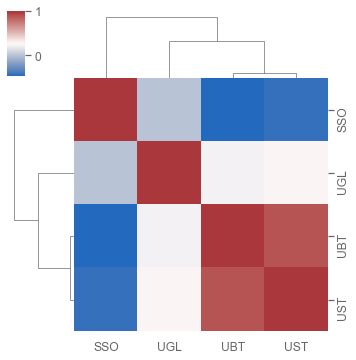

In [6]:
corr = data_r.corr()
print(corr)
sns.clustermap(corr, figsize=(5,5), cmap='vlag')

In [7]:
display(utl.describe_sr(data_r))

,SSO,UBT,UST,UGL
Return,0.279879,0.124182,0.061071,0.079224
Volatility,0.342758,0.288199,0.118551,0.316941
Sharpe,0.816550,0.430888,0.515145,0.249963
Skew,-0.570156,-0.061714,-0.054217,-0.413418
Kurt,14.446975,4.678978,1.817326,5.070557
Max DD,-0.593411,-0.445087,-0.211357,-0.759253
mean,0.001111,0.000493,0.000242,0.000315
std,0.021598,0.018160,0.007470,0.019971
min,-0.233582,-0.156310,-0.036097,-0.176118
25%,-0.006918,-0.010335,-0.004245,-0.009769


## Creating function to build the portfolio 

In [8]:
def df_inverse_volatility(df_perc, window):
    
    #compute the  1 / volatility (standard_deviation) over a range of days - n° days = window
    return df_perc.rolling(window).apply(lambda x: 1/(x.std()))

In [9]:
def df_wheighted(inv_volat_df):
    
    #create a new df with the same columns
    df = pd.DataFrame(columns = inv_volat_df.columns)
    
    #iterate over rows (always avoid it, if possible) 
    for index, row in inv_volat_df.iterrows():
        
        #append the new value at each row
        df.loc[index] = row.div(sum(list(row)))
    return df

In [10]:
def df_earnings(df_weight_portf, data_r):
    
    #compte the earning dataframe (df_weight*df_percentage - entries by entries)
    return df_weight_portf*data_r

## Calling the funtion to build the dataframe 

In [11]:
inv_volat_df =  df_inverse_volatility(data_r, 30)
inv_volat_df.dropna(inplace= True)
df_weight_portf = df_wheighted(inv_volat_df)
#df_weight_portf

df_return = df_earnings(df_weight_portf, data_r)
df_return.dropna(inplace = True)
df_return['Tot'] = df_return.sum(axis=1)
df_return 

,SSO,UBT,UST,UGL,Tot
2010-03-17,0.002168,0.001907,0.001081,-0.001976,0.003180
2010-03-18,-0.000171,-0.001635,0.000000,0.001858,0.000052
2010-03-19,-0.002173,0.000894,-0.002625,-0.004883,-0.008787
2010-03-22,0.002178,0.000428,0.001153,-0.001499,0.002259
2010-03-23,0.003270,-0.002035,-0.000539,0.001240,0.001936
...,...,...,...,...,...
2022-03-14,-0.002500,-0.009722,-0.009763,-0.006947,-0.028931
2022-03-15,0.007312,-0.000653,-0.000485,-0.007434,-0.001260
2022-03-16,0.007355,0.004179,-0.001751,0.002066,0.011849
2022-03-17,0.004051,-0.003227,-0.001270,0.001950,0.001504


## Evaluating the portfolio

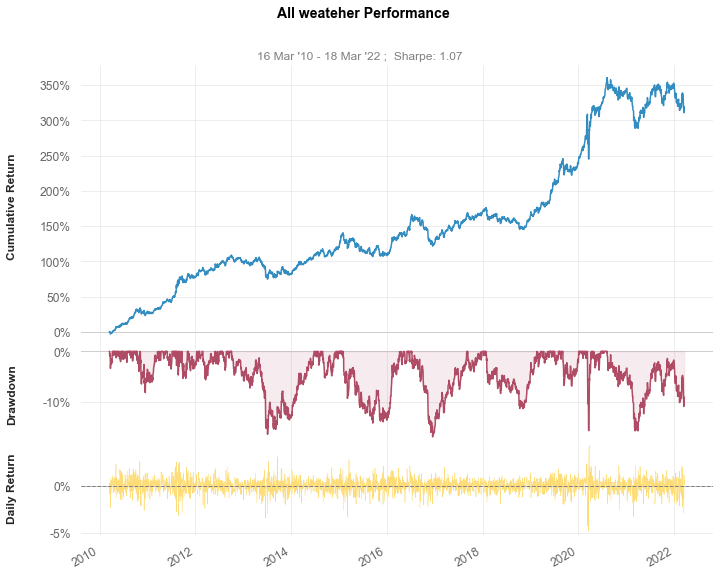

In [12]:
qs.plots.snapshot(df_return['Tot'], title='All weateher Performance')

                           Strategy
-------------------------  ----------
Start Period               2010-03-17
End Period                 2022-03-18
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          319.19%
CAGR﹪                     12.67%

Sharpe                     1.07
Smart Sharpe               1.03
Sortino                    1.53
Smart Sortino              1.48
Sortino/√2                 1.08
Smart Sortino/√2           1.05
Omega                      1.2

Max Drawdown               -16.79%
Longest DD Days            629
Volatility (ann.)          11.85%
Calmar                     0.75
Skew                       -0.3
Kurtosis                   3.01

Expected Daily %           0.05%
Expected Monthly %         0.99%
Expected Yearly %          11.65%
Kelly Criterion            9.16%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.18%
Expected Shortfall (cVaR)  -1.18%

Gain/Pain Ratio            0.2
Gain/Pain (1M)             1

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2016-07-11,2016-12-15,2017-09-05,421,-16.793833,-16.161815
2,2012-10-04,2013-07-05,2014-06-25,629,-16.279315,-15.067497
3,2020-08-07,2021-03-30,2022-03-18,588,-15.608743,-15.086231
4,2020-03-10,2020-03-19,2020-04-09,30,-15.574939,-15.192267
5,2015-02-02,2015-09-15,2016-04-19,442,-14.089930,-13.597482


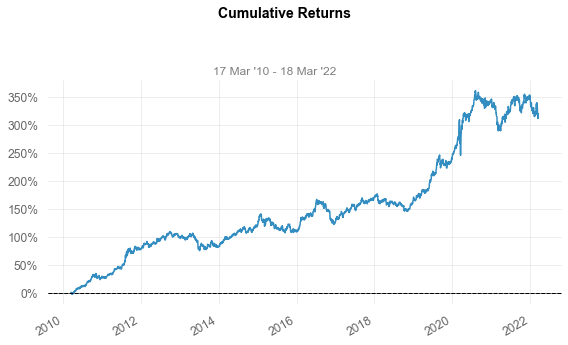

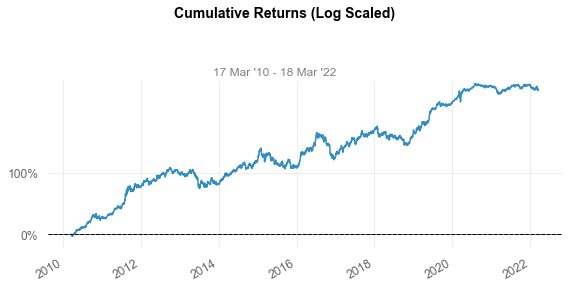

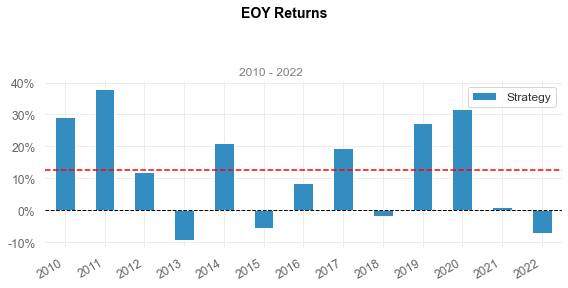

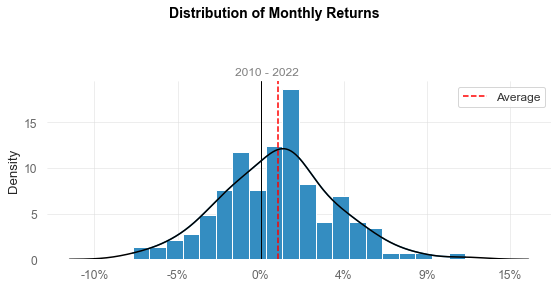

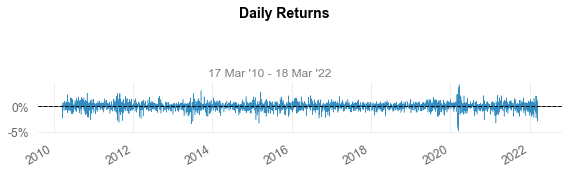

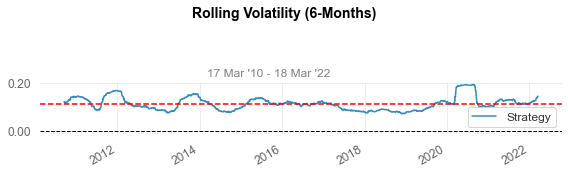

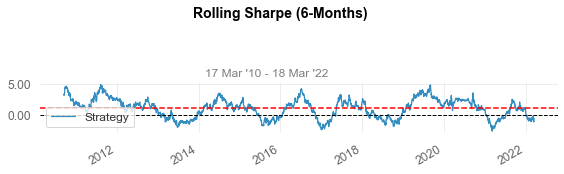

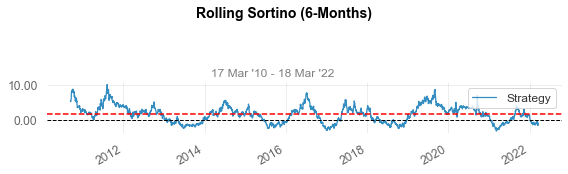

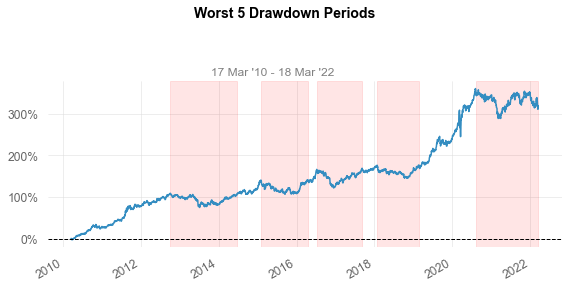

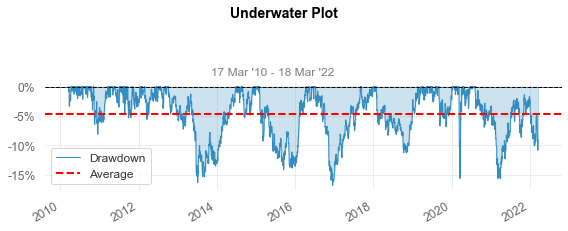

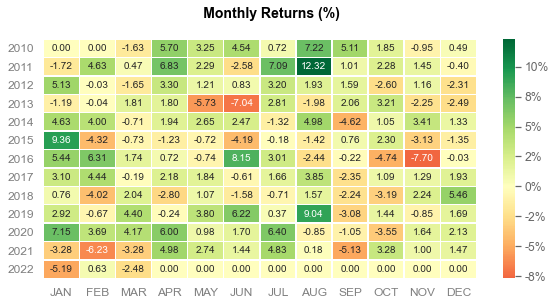

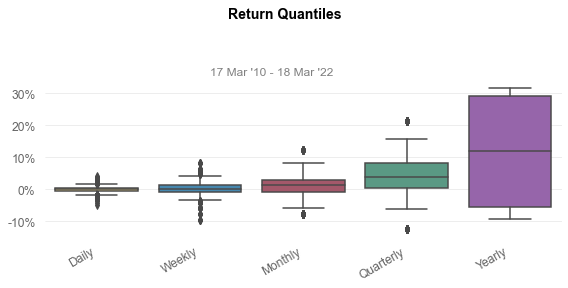

In [13]:
#full report
qs.reports.full(df_return['Tot'])

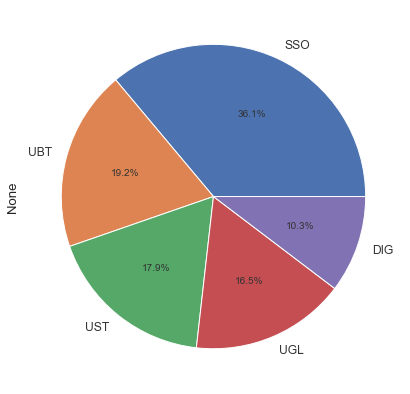

In [17]:
#plot of the average composition of the portfolio (over the year?!?)
plot = df_return.drop('Tot', axis=1).sum(axis=0).plot.pie(figsize=(7, 7),autopct='%1.1f%%')


## Function to compute the number of securities

In [15]:
def compute_number_of_securities(df_weight_portf, investment, data):
    
    #multiply the wheighted df for the investment to see how the capital is shared between the securities
    df = df_weight_portf.mul(investment)
    
    #divide by the close price of the day to get the number of securities I can buy
    df = df / data
    
    #convert to integer -> issue: some money are not spent!!
    df = df.dropna().astype(int)
    return df

In [16]:
compute_number_of_securities(df_weight_portf, 10000, data)

,SSO,UBT,UST,UGL
2010-03-17,371,138,141,29
2010-03-18,364,141,143,27
2010-03-19,443,134,134,29
2010-03-22,435,133,135,29
2010-03-23,448,132,134,29
...,...,...,...,...
2022-02-28,23,40,63,38
2022-03-01,24,41,62,35
2022-03-02,24,39,65,36
2022-03-03,24,38,64,37
